In [36]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Reading the data

In [37]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [38]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [39]:
class_names = ["Tshirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

### Building the Model

In [40]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")], name="Mnist_Model")

In [41]:
model.summary()

Model: "Mnist_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid))

Epoch 1/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7168 - accuracy: 0.7651 - val_loss: 0.5235 - val_accuracy: 0.8174
Epoch 2/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4856 - accuracy: 0.8310 - val_loss: 0.4774 - val_accuracy: 0.8342
Epoch 3/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4409 - accuracy: 0.8468 - val_loss: 0.4228 - val_accuracy: 0.8552
Epoch 4/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4140 - accuracy: 0.8555 - val_loss: 0.3900 - val_accuracy: 0.8646
Epoch 5/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3950 - accuracy: 0.8614 - val_loss: 0.3828 - val_accuracy: 0.8666
Epoch 6/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3789 - accuracy: 0.8667 - val_loss: 0.3832 - val_accuracy: 0.8652
Epoch 7/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3644 - accuracy: 0.8719 - val_loss: 0.3738 - val_ac

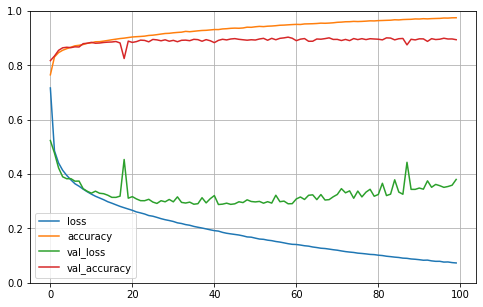

In [43]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [44]:
model.evaluate(X_test, y_test, batch_size=1)

10000/10000 [==============================] - 11s 1ms/step - loss: 126.2993 - accuracy: 0.8300


[126.29926300048828, 0.8299999833106995]

### Predictions

In [45]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(3)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [46]:
X_new = X_test[:3]
y_pred = model.predict_classes(X_new)
y_pred

array([9, 2, 1], dtype=int64)

In [48]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U10')

### Save the model in Savedmodel format

In [54]:
import os
model_version = "0001"
model_name = "my_mnist_model"
model_path = os.path.join(model_name, model_version)
tf.keras.models.save_model(model, model_path)

INFO:tensorflow:Assets written to: my_mnist_model\0001\assets


In [58]:
# run on anaconda cli, after activating your conda env and going to the project directory
#saved_model_cli show --dir model_path --all

##### load the model and predcit: using the savel_model cli

In [ ]:
np.save("my_mnist_test.npy", X_new)
# saved_model_cli run --dir my_mnist_model/0001 --tag_set serve --signature_def serving_default --inputs flatten_1_input=my_mnist_test.npy

##### load the model and predict: simple methode

In [64]:
saved_model = tf.keras.models.load_model(model_path) 
y_pred = saved_model(X_new, training=False)
y_pred

<tf.Tensor: shape=(3, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

##### load the model and predict: wrap the saved model as keras model

In [68]:
inputs = keras.layers.Input(shape=[28,28])
outputs = saved_model(inputs, training=False)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
y_preds = model.predict(X_new)
y_preds

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

## Exposing the savedModel for use using TF serving 

We will be using docker to run our tf serving server

In [ ]:
# docker pull tensorflow/serving
# docker run -it --rm -p 8500:8500 -p 8501:8501 \
#            -v 'Tensorflow-at-scale/my_mnist_model:/models/my_mnist_model' \ 
#            -e MODEL_NAME = my_mnist_model \
#            tensorflow/serving

 Once the tf serving server is up and running, we can query it using the Rest Api or the gRPC Api: (both dispo at ports 8500 and 8501 respectively)

## Querying via Rest API

## Querying via gRPC API